In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install shap


In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import pickle as p
from tqdm import tqdm

In [ ]:
base_path="/content/drive/MyDrive/nfl-big-data-bowl-2024/"

In [ ]:
dfgames = pd.read_csv(base_path+"games.csv")
dfplayers = pd.read_csv(base_path+"players.csv")
dfplays = pd.read_csv(base_path+"plays.csv")
dftackles = pd.read_csv(base_path+"tackles.csv")
df_track=pd.read_parquet(base_path+"df_tracking.parquet")

In [ ]:
print(dfgames.columns)
print(dfplayers.columns)
print(dfplays.columns)
print(dftackles.columns)
print(df_track.columns)

Index(['gameId', 'season', 'week', 'gameDate', 'gameTimeEastern',
       'homeTeamAbbr', 'visitorTeamAbbr', 'homeFinalScore',
       'visitorFinalScore'],
      dtype='object')
Index(['nflId', 'height', 'weight', 'birthDate', 'collegeName', 'position',
       'displayName'],
      dtype='object')
Index(['gameId', 'playId', 'ballCarrierId', 'ballCarrierDisplayName',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'offenseFormation',
       'defendersInTheBox', 'passProbability', 'preSnapHomeTeamWinProbability',
       'preSnapVisitorTeamWinProbability', 'homeTeamWinProbabilityAdded',
       'visitorTeamWinProbilityAdded', 'expectedPoints', 'expectedPointsAdded',
       'foulName1', 'foulName2', 

In [ ]:
games = {}
for gameId in dfgames['gameId']:
	games[gameId] = df_track[df_track['gameId']==gameId]

In [ ]:
import pandas as pd
import pickle as p
from scipy.spatial import distance
import math


def closest_node(center_point, surrounding_points):
    closest_index = distance.cdist([center_point], surrounding_points).argmin()
    return surrounding_points[closest_index]



In [ ]:
# Function to calculate the distance between two points
def calculateDistance(x1,y1,x2,y2):
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
     return dist



In [ ]:
def addCatchSeparation2(indf, dfplays=dfplays, dfgames= dfgames): #indf:- dataframe with unique game id ,play id and event=caught
  df_ball_tracking=pd.DataFrame()
  game= indf["gameId"].values[0]
  playid= indf["playId"].values[0]

  #info about catcher
  carrier=dfplays[(dfplays["gameId"]==game)&(dfplays["playId"]==playid)]["ballCarrierId"].values[0]
  df_ball_tracking=pd.concat([df_ball_tracking,indf[(indf["gameId"]==game)&(indf["playId"]==playid)&(indf["nflId"]==carrier)]])

  #info about defending team
  def_team=dfplays[(dfplays["gameId"]==game)&(dfplays["playId"]==playid)]["defensiveTeam"].values[0]
  df_team_data=indf[(indf["frameId"]==df_ball_tracking["frameId"].values[0])&(indf['club']==def_team)]


  player_points = df_team_data[['x','y']].values
  receiver_x= df_ball_tracking['x'].values[0]
  receiver_y= df_ball_tracking['y'].values[0]

  #closest defender to ball
  closest_player_coordinates = closest_node((receiver_x, receiver_y), player_points)


  #closest defender info
  corner_player = df_team_data[(df_team_data['x'] == closest_player_coordinates[0]) & (df_team_data['y'] == closest_player_coordinates[1])]
  corner_distance = calculateDistance(df_ball_tracking['x'].values[0], df_ball_tracking['y'].values[0],corner_player['x'].values[0], corner_player['y'].values[0])

  dfcatch_wSeparation= pd.DataFrame()

  offense_team= df_ball_tracking['club'].values[0]
  defense_team= df_ball_tracking['club'].values[0]

  home_team= dfgames[dfgames['gameId']==game]['homeTeamAbbr'].values[0]
  away_team= dfgames[dfgames['gameId']==game]['visitorTeamAbbr'].values[0]

  dfcatch_wSeparation['gameId'] = df_ball_tracking['gameId']
  dfcatch_wSeparation['playId'] = df_ball_tracking['playId']
  dfcatch_wSeparation['catchSeparation'] = corner_distance
  dfcatch_wSeparation['catchingReceiver'] = df_ball_tracking['displayName'].values[0]
  dfcatch_wSeparation['closestCorner'] = corner_player['displayName'].values[0]
  dfcatch_wSeparation['receiver x'] = df_ball_tracking['x'].values[0]
  dfcatch_wSeparation['receiver y'] = df_ball_tracking['y'].values[0]

  if (offense_team == home_team):
    dfcatch_wSeparation['offense'] = "home"
    dfcatch_wSeparation['defense'] = "away"
  else:
    dfcatch_wSeparation['offense'] = "away"
    dfcatch_wSeparation['defense'] = "home"
  return dfcatch_wSeparation

In [ ]:
import pandas as pd

def addCatchSeparation(indf, dfplays=dfplays, dfgames=dfgames):

    # Extract game and play ID
    game_id = indf["gameId"].values[0]
    play_id = indf["playId"].values[0]

    # Retrieve ball carrier (catching receiver) information
    carrier_id = dfplays[(dfplays["gameId"] == game_id) & (dfplays["playId"] == play_id)]["ballCarrierId"].values[0]
    df_ball_tracking = indf[(indf["nflId"] == carrier_id)]

    # Retrieve defending team and their players' positions
    defensive_team = dfplays[(dfplays["gameId"] == game_id) & (dfplays["playId"] == play_id)]["defensiveTeam"].values[0]
    df_team_data = indf[(indf["frameId"] == df_ball_tracking["frameId"].values[0]) & (indf['club'] == defensive_team)]

    # Get positions of defensive players and the receiver's position
    defensive_positions = df_team_data[['x', 'y']].values
    receiver_x, receiver_y = df_ball_tracking['x'].values[0], df_ball_tracking['y'].values[0]

    # Find closest defender to the ball carrier
    closest_defender_coords = closest_node((receiver_x, receiver_y), defensive_positions)
    closest_defender = df_team_data[(df_team_data['x'] == closest_defender_coords[0]) &
                                    (df_team_data['y'] == closest_defender_coords[1])]

    # Calculate the distance (catch separation) between the receiver and the closest defender
    catch_separation = calculateDistance(receiver_x, receiver_y,
                                         closest_defender['x'].values[0], closest_defender['y'].values[0])

    # Determine offense and defense teams
    offense_team = df_ball_tracking['club'].values[0]
    home_team = dfgames[dfgames['gameId'] == game_id]['homeTeamAbbr'].values[0]
    away_team = dfgames[dfgames['gameId'] == game_id]['visitorTeamAbbr'].values[0]

    # Assign 'home' or 'away' labels to offense and defense
    offense_label = "home" if offense_team == home_team else "away"
    defense_label = "away" if offense_team == home_team else "home"

    # Create the output DataFrame with consistent column names
    dfcatch_wSeparation = pd.DataFrame({
        'gameId': [game_id],
        'playId': [play_id],
        'catchSeparation': [catch_separation],
        'catchingReceiver': [df_ball_tracking['displayName'].values[0]],
        'closestCorner': [closest_defender['displayName'].values[0]],
        'receiver x': [receiver_x],
        'receiver y': [receiver_y],
        'offense': [offense_label],
        'defense': [defense_label]
    })

    return dfcatch_wSeparation


In [ ]:
import pandas as pd

def process_play(play, dfgame):
    try:
        playdf = dfgame[dfgame['playId'] == play]
        catch_frame = playdf[playdf['event'] == 'pass_outcome_caught']['frameId'].values[0]
        indf = playdf[playdf['frameId'] == catch_frame]
        return addCatchSeparation(indf)
    except Exception as e:
        print(f"Failed to calculate catch separation for play {play} in game {dfgame['gameId'].iloc[0]}")
        print(e)
        return None

def process_game(game_id, games):

    dfgame = games[game_id]
    play_ids = dfgame[dfgame['event'] == 'pass_outcome_caught']['playId'].unique()

    game_df = pd.DataFrame()
    for play in play_ids:
        play_df = process_play(play, dfgame)
        if play_df is not None:
            game_df = pd.concat([game_df, play_df], ignore_index=True)

    # Select distinct plays with specific columns
    return game_df[['gameId', 'playId', 'catchingReceiver', 'closestCorner',
                    'receiver x', 'receiver y', 'catchSeparation',
                    'offense', 'defense']].drop_duplicates()

def compile_games_data(games):

    main_df = pd.DataFrame()
    for main_counter, game_id in enumerate(games):
        game_df = process_game(game_id, games)
        main_df = pd.concat([main_df, game_df], ignore_index=True)

    return main_df

# Example usage to generate the main DataFrame
main_df = compile_games_data(games)


In [ ]:
main_df

,gameId,playId,catchingReceiver,closestCorner,receiver x,receiver y,catchSeparation,offense,defense
0,2022090800,56,Stefon Diggs,Jalen Ramsey,79.85,35.59,2.828003,away,home
1,2022090800,122,Devin Singletary,Aaron Donald,67.89,38.41,4.278329,away,home
2,2022090800,167,Stefon Diggs,Leonard Floyd,51.68,27.87,2.462214,away,home
3,2022090800,212,Zack Moss,Bobby Wagner,37.68,46.87,0.861452,away,home
4,2022090800,236,Gabe Davis,Nick Scott,19.30,44.85,8.202103,away,home
...,...,...,...,...,...,...,...,...,...
5649,2022110700,3323,Chris Olave,Marcus Peters,21.33,11.04,6.595787,home,away
5650,2022110700,3347,Tre'Quan Smith,Kyle Hamilton,39.40,45.53,1.299577,home,away
5651,2022110700,3401,Tre'Quan Smith,Marcus Peters,49.66,15.26,0.305287,home,away
5652,2022110700,3429,Alvin Kamara,Patrick Queen,53.47,20.74,8.106948,home,away


In [ ]:
main_df2 = main_df.copy(deep=True)
main_df2

,gameId,playId,catchingReceiver,closestCorner,receiver x,receiver y,catchSeparation,offense,defense
0,2022090800,56,Stefon Diggs,Jalen Ramsey,79.85,35.59,2.828003,away,home
1,2022090800,122,Devin Singletary,Aaron Donald,67.89,38.41,4.278329,away,home
2,2022090800,167,Stefon Diggs,Leonard Floyd,51.68,27.87,2.462214,away,home
3,2022090800,212,Zack Moss,Bobby Wagner,37.68,46.87,0.861452,away,home
4,2022090800,236,Gabe Davis,Nick Scott,19.30,44.85,8.202103,away,home
...,...,...,...,...,...,...,...,...,...
5649,2022110700,3323,Chris Olave,Marcus Peters,21.33,11.04,6.595787,home,away
5650,2022110700,3347,Tre'Quan Smith,Kyle Hamilton,39.40,45.53,1.299577,home,away
5651,2022110700,3401,Tre'Quan Smith,Marcus Peters,49.66,15.26,0.305287,home,away
5652,2022110700,3429,Alvin Kamara,Patrick Queen,53.47,20.74,8.106948,home,away


In [ ]:
%%time
from tqdm import tqdm

# Iterate over main_df2 rows with progress tracking
for index, row in tqdm(main_df2.iterrows(), total=len(main_df2), desc="Processing main_df"):
    # Select relevant data for current game and play
    game_id, play_id = row['gameId'], row['playId']
    df = games[game_id]

    # Add player position information to the current game DataFrame
    df = df.join(dfplayers[['nflId', 'position']].set_index('nflId'), on='nflId')
    dfplay = df[df['playId'] == play_id]

    # Initialize counter for teammates of the catching receiver
    receiver_mate_counter = 0
    catching_receiver = row['catchingReceiver']
    catching_receiver_team = dfplay[dfplay['displayName'] == catching_receiver]['club'].values[0]

    # Filter players in relevant positions who caught the pass
    receiver_candidates = dfplay[(dfplay['event'] == 'pass_outcome_caught') &
                                 (dfplay['position'].isin(['TE', 'WR', 'RB', 'FB']))]['displayName'].unique()

    for display_name in receiver_candidates:
        player_team = dfplay[dfplay['displayName'] == display_name]['club'].values[0]

        # Skip players from the opposing team
        if player_team != catching_receiver_team:
            continue

        # Calculate distance between this player and the catching receiver
        player_position = dfplay[(dfplay['displayName'] == display_name) &
                                 (dfplay['event'] == 'pass_outcome_caught')][['x', 'y']].values[0]
        receiver_position = dfplay[(dfplay['displayName'] == catching_receiver) &
                                   (dfplay['event'] == 'pass_outcome_caught')][['x', 'y']].values[0]
        dist = calculateDistance(player_position[0], player_position[1], receiver_position[0], receiver_position[1])

        # Check if the player is the actual catching receiver
        if display_name == catching_receiver:
            continue  # Skip as this is the main receiver

        # Assign calculated distance to the appropriate column in main_df2
        receiver_mate_counter += 1
        main_df2.loc[index, f'ReceiverMate_distance{receiver_mate_counter}'] = dist


Processing main_df: 100%|██████████| 5654/5654 [03:23<00:00, 27.82it/s]

CPU times: user 3min 17s, sys: 1.99 s, total: 3min 19s
Wall time: 3min 23s


In [ ]:
main_df2

,gameId,playId,catchingReceiver,closestCorner,receiver x,receiver y,catchSeparation,offense,defense,ReceiverMate_distance1,ReceiverMate_distance2,ReceiverMate_distance3,ReceiverMate_distance4,ReceiverMate_distance5
0,2022090800,56,Stefon Diggs,Jalen Ramsey,79.85,35.59,2.828003,away,home,19.698370,14.164071,7.846349,30.631203,NaN
1,2022090800,122,Devin Singletary,Aaron Donald,67.89,38.41,4.278329,away,home,21.714442,21.400654,7.820006,36.060733,NaN
2,2022090800,167,Stefon Diggs,Leonard Floyd,51.68,27.87,2.462214,away,home,12.300346,19.108357,16.669091,13.882737,NaN
3,2022090800,212,Zack Moss,Bobby Wagner,37.68,46.87,0.861452,away,home,14.479896,36.898271,11.122769,22.938653,NaN
4,2022090800,236,Gabe Davis,Nick Scott,19.30,44.85,8.202103,away,home,19.323418,26.688252,33.816617,30.118109,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,2022110700,3323,Chris Olave,Marcus Peters,21.33,11.04,6.595787,home,away,27.879473,3.469179,7.126977,30.462188,NaN
5650,2022110700,3347,Tre'Quan Smith,Kyle Hamilton,39.40,45.53,1.299577,home,away,23.931172,38.001107,9.266612,40.793623,NaN
5651,2022110700,3401,Tre'Quan Smith,Marcus Peters,49.66,15.26,0.305287,home,away,11.660193,21.613850,11.845155,36.520222,NaN
5652,2022110700,3429,Alvin Kamara,Patrick Queen,53.47,20.74,8.106948,home,away,18.343732,11.316559,18.294874,27.282756,NaN


In [ ]:
main_df3 = main_df2.copy(deep=True)
main_df3 = main_df3.drop(['ReceiverMate_distance5'], axis=1)

# Isolate play features to be used in training (and gameId and playId to merge to main dataset)
play_features = dfplays[['gameId','playId','down','yardsToGo','offenseFormation','defendersInTheBox','passProbability', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded']]

# Merge play features to main data
main_df3 = pd.merge(main_df3, play_features,  how='left', on=['gameId','playId'])

# Select only the rows where the following columns have no null values

main_df3 = main_df3[main_df3.ReceiverMate_distance4.notnull()][main_df3.ReceiverMate_distance3.notnull()][main_df3.ReceiverMate_distance2.notnull()][main_df3.ReceiverMate_distance1.notnull()][main_df3.catchSeparation.notnull()][main_df3.down.notnull()][main_df3.yardsToGo.notnull()][main_df3.offenseFormation.notnull()][main_df3.defendersInTheBox.notnull()][main_df3.passProbability.notnull()][main_df3['homeTeamWinProbabilityAdded'].notnull()][main_df3['visitorTeamWinProbilityAdded'].notnull()]
# Output the result to a csv file

<ipython-input-122-a527150d9c49>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df3 = main_df3[main_df3.ReceiverMate_distance4.notnull()][main_df3.ReceiverMate_distance3.notnull()][main_df3.ReceiverMate_distance2.notnull()][main_df3.ReceiverMate_distance1.notnull()][main_df3.catchSeparation.notnull()][main_df3.down.notnull()][main_df3.yardsToGo.notnull()][main_df3.offenseFormation.notnull()][main_df3.defendersInTheBox.notnull()][main_df3.passProbability.notnull()][main_df3['homeTeamWinProbabilityAdded'].notnull()][main_df3['visitorTeamWinProbilityAdded'].notnull()]
<ipython-input-122-a527150d9c49>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  main_df3 = main_df3[main_df3.ReceiverMate_distance4.notnull()][main_df3.ReceiverMate_distance3.notnull()][main_df3.ReceiverMate_distance2.notnull()][main_df3.ReceiverMate_distance1.notnull()][main_df3.catchSeparation.notnull()][main_df3.down.notnull()][main_df3.yardsToGo.n

In [ ]:
main_df3.to_csv('/content/drive/My Drive/nfl-big-data-bowl-2024/main_df.csv', index=False)

In [ ]:
main_df3

,gameId,playId,catchingReceiver,closestCorner,receiver x,receiver y,catchSeparation,offense,defense,ReceiverMate_distance1,ReceiverMate_distance2,ReceiverMate_distance3,ReceiverMate_distance4,down,yardsToGo,offenseFormation,defendersInTheBox,passProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded
0,2022090800,56,Stefon Diggs,Jalen Ramsey,79.85,35.59,2.828003,away,home,19.698370,14.164071,7.846349,30.631203,1,10,SHOTGUN,6.0,0.689960,-0.000031,0.000031
1,2022090800,122,Devin Singletary,Aaron Donald,67.89,38.41,4.278329,away,home,21.714442,21.400654,7.820006,36.060733,2,3,SHOTGUN,6.0,0.686939,-0.019032,0.019032
2,2022090800,167,Stefon Diggs,Leonard Floyd,51.68,27.87,2.462214,away,home,12.300346,19.108357,16.669091,13.882737,2,8,EMPTY,6.0,0.903882,-0.031870,0.031870
3,2022090800,212,Zack Moss,Bobby Wagner,37.68,46.87,0.861452,away,home,14.479896,36.898271,11.122769,22.938653,2,9,SHOTGUN,6.0,0.880736,-0.018238,0.018238
4,2022090800,236,Gabe Davis,Nick Scott,19.30,44.85,8.202103,away,home,19.323418,26.688252,33.816617,30.118109,3,1,I_FORM,7.0,0.225846,-0.063681,0.063681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,2022110700,3323,Chris Olave,Marcus Peters,21.33,11.04,6.595787,home,away,27.879473,3.469179,7.126977,30.462188,3,14,SHOTGUN,6.0,0.961079,0.000018,-0.000018
5650,2022110700,3347,Tre'Quan Smith,Kyle Hamilton,39.40,45.53,1.299577,home,away,23.931172,38.001107,9.266612,40.793623,4,3,SHOTGUN,6.0,0.947344,-0.000021,0.000021
5651,2022110700,3401,Tre'Quan Smith,Marcus Peters,49.66,15.26,0.305287,home,away,11.660193,21.613850,11.845155,36.520222,2,10,SHOTGUN,6.0,0.845756,0.000281,-0.000281
5652,2022110700,3429,Alvin Kamara,Patrick Queen,53.47,20.74,8.106948,home,away,18.343732,11.316559,18.294874,27.282756,3,1,SHOTGUN,6.0,0.524299,-0.000030,0.000030


In [ ]:
main_df3[(main_df3['gameId']==2022092900) & (main_df3['playId']==615)]
main_df3 = main_df3[~((main_df3['gameId'] == 2022092900) & (main_df3['playId'] == 615))]

In [ ]:
main_df3

,gameId,playId,catchingReceiver,closestCorner,receiver x,receiver y,catchSeparation,offense,defense,ReceiverMate_distance1,ReceiverMate_distance2,ReceiverMate_distance3,ReceiverMate_distance4,down,yardsToGo,offenseFormation,defendersInTheBox,passProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded
0,2022090800,56,Stefon Diggs,Jalen Ramsey,79.85,35.59,2.828003,away,home,19.698370,14.164071,7.846349,30.631203,1,10,SHOTGUN,6.0,0.689960,-0.000031,0.000031
1,2022090800,122,Devin Singletary,Aaron Donald,67.89,38.41,4.278329,away,home,21.714442,21.400654,7.820006,36.060733,2,3,SHOTGUN,6.0,0.686939,-0.019032,0.019032
2,2022090800,167,Stefon Diggs,Leonard Floyd,51.68,27.87,2.462214,away,home,12.300346,19.108357,16.669091,13.882737,2,8,EMPTY,6.0,0.903882,-0.031870,0.031870
3,2022090800,212,Zack Moss,Bobby Wagner,37.68,46.87,0.861452,away,home,14.479896,36.898271,11.122769,22.938653,2,9,SHOTGUN,6.0,0.880736,-0.018238,0.018238
4,2022090800,236,Gabe Davis,Nick Scott,19.30,44.85,8.202103,away,home,19.323418,26.688252,33.816617,30.118109,3,1,I_FORM,7.0,0.225846,-0.063681,0.063681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,2022110700,3323,Chris Olave,Marcus Peters,21.33,11.04,6.595787,home,away,27.879473,3.469179,7.126977,30.462188,3,14,SHOTGUN,6.0,0.961079,0.000018,-0.000018
5650,2022110700,3347,Tre'Quan Smith,Kyle Hamilton,39.40,45.53,1.299577,home,away,23.931172,38.001107,9.266612,40.793623,4,3,SHOTGUN,6.0,0.947344,-0.000021,0.000021
5651,2022110700,3401,Tre'Quan Smith,Marcus Peters,49.66,15.26,0.305287,home,away,11.660193,21.613850,11.845155,36.520222,2,10,SHOTGUN,6.0,0.845756,0.000281,-0.000281
5652,2022110700,3429,Alvin Kamara,Patrick Queen,53.47,20.74,8.106948,home,away,18.343732,11.316559,18.294874,27.282756,3,1,SHOTGUN,6.0,0.524299,-0.000030,0.000030


In [ ]:
df = df_track.dropna(subset=['event']).reset_index(drop=True)

In [ ]:
from typing_extensions import final
def find_next_event(group):
    global count
    group = group.reset_index(drop=True)
    # Locate the index of the last 'pass_outcome_caught' event in the group
    catch_idx = group[group['event'] == 'pass_outcome_caught'].index
    if len(catch_idx) == 0:
        return 0,0,"Not applicable", 0  # No 'pass_outcome_caught' event found

    # Get the index of the last 'pass_outcome_caught'
    last_catch_idx = catch_idx[-1]
    next_event_idx = last_catch_idx + 1
    initial_dis = group.loc[last_catch_idx, 'x']
    playdirection = group.loc[last_catch_idx, 'playDirection']
    gameId = group.loc[last_catch_idx, 'gameId']
    playId = group.loc[last_catch_idx, 'playId']
    # Find the next event after the last 'pass_outcome_caught', if it exists
    # Loop to skip consecutive 'first_contact' events
    while next_event_idx < len(group) and group.loc[next_event_idx, 'event'] == 'first_contact':
        next_event_idx += 1  # Move to the next event index

    # Check if a valid next event was found
    if next_event_idx < len(group):
        next_event = group.loc[next_event_idx, 'event']
        distance = 0
        if next_event == 'tackle' or next_event == 'out_of_bounds':
            final_dis = group.loc[next_event_idx, 'x']
            if initial_dis > final_dis and playdirection == 'left':
                distance = initial_dis - final_dis
            elif final_dis > initial_dis and playdirection == 'right':
                distance = final_dis - initial_dis
        return gameId,playId,next_event, distance
    else:
        return gameId,playId,"End of group", 0  # No next non-'first_contact' event found

# Apply the function across groups and unpack the results into two columns
result = df.groupby(['gameId', 'playId']).apply(find_next_event).reset_index(level=[0, 1], drop=True)

# Convert the result to a DataFrame with separate columns for event and distance
result_df = pd.DataFrame(result.tolist(), columns=['gameId','playId','next_event_after_catch', 'distance'])

# Display the result
print(result_df)


           gameId  playId next_event_after_catch  distance
0      2022090800      56                 tackle  0.059998
1               0       0         Not applicable  0.000000
2               0       0         Not applicable  0.000000
3      2022090800     122                 tackle  8.269997
4               0       0         Not applicable  0.000000
...           ...     ...                    ...       ...
12481           0       0         Not applicable  0.000000
12482           0       0         Not applicable  0.000000
12483           0       0         Not applicable  0.000000
12484           0       0         Not applicable  0.000000
12485           0       0         Not applicable  0.000000

[12486 rows x 4 columns]


<ipython-input-128-00ab51e1d329>:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby(['gameId', 'playId']).apply(find_next_event).reset_index(level=[0, 1], drop=True)


In [ ]:
import numpy as np
#we consider outcomes where after catching, the next event is tackle/out of bounds and give a successful play when the covered yards>5
result_df['pass_outcome'] = np.where(
    ~result_df['next_event_after_catch'].isin(['tackle', 'out_of_bounds']),
    1,
    np.where(result_df['distance'] > 5, 1, 0)
)


In [ ]:
result_df2 = result_df[result_df['next_event_after_catch']!='Not applicable']

In [ ]:
final_df = result_df2[['gameId', 'playId', 'pass_outcome']]
final_df


,gameId,playId,pass_outcome
0,2022090800,56,0
3,2022090800,122,1
5,2022090800,167,1
7,2022090800,212,0
8,2022090800,236,1
...,...,...,...
12472,2022110700,3323,1
12473,2022110700,3347,0
12474,2022110700,3401,0
12475,2022110700,3429,1


In [ ]:
main_df4 = pd.merge(main_df3, final_df,  how='left', on=['gameId','playId'])

# main_df4.to_csv('/content/drive/My Drive/nfl-big-data-bowl-2024/main_df5.csv', index=False)
main_df4


,gameId,playId,catchingReceiver,closestCorner,receiver x,receiver y,catchSeparation,offense,defense,ReceiverMate_distance1,...,ReceiverMate_distance3,ReceiverMate_distance4,down,yardsToGo,offenseFormation,defendersInTheBox,passProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,pass_outcome
0,2022090800,56,Stefon Diggs,Jalen Ramsey,79.85,35.59,2.828003,away,home,19.698370,...,7.846349,30.631203,1,10,SHOTGUN,6.0,0.689960,-0.000031,0.000031,0
1,2022090800,122,Devin Singletary,Aaron Donald,67.89,38.41,4.278329,away,home,21.714442,...,7.820006,36.060733,2,3,SHOTGUN,6.0,0.686939,-0.019032,0.019032,1
2,2022090800,167,Stefon Diggs,Leonard Floyd,51.68,27.87,2.462214,away,home,12.300346,...,16.669091,13.882737,2,8,EMPTY,6.0,0.903882,-0.031870,0.031870,1
3,2022090800,212,Zack Moss,Bobby Wagner,37.68,46.87,0.861452,away,home,14.479896,...,11.122769,22.938653,2,9,SHOTGUN,6.0,0.880736,-0.018238,0.018238,0
4,2022090800,236,Gabe Davis,Nick Scott,19.30,44.85,8.202103,away,home,19.323418,...,33.816617,30.118109,3,1,I_FORM,7.0,0.225846,-0.063681,0.063681,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459,2022110700,3323,Chris Olave,Marcus Peters,21.33,11.04,6.595787,home,away,27.879473,...,7.126977,30.462188,3,14,SHOTGUN,6.0,0.961079,0.000018,-0.000018,1
5460,2022110700,3347,Tre'Quan Smith,Kyle Hamilton,39.40,45.53,1.299577,home,away,23.931172,...,9.266612,40.793623,4,3,SHOTGUN,6.0,0.947344,-0.000021,0.000021,0
5461,2022110700,3401,Tre'Quan Smith,Marcus Peters,49.66,15.26,0.305287,home,away,11.660193,...,11.845155,36.520222,2,10,SHOTGUN,6.0,0.845756,0.000281,-0.000281,0
5462,2022110700,3429,Alvin Kamara,Patrick Queen,53.47,20.74,8.106948,home,away,18.343732,...,18.294874,27.282756,3,1,SHOTGUN,6.0,0.524299,-0.000030,0.000030,1


In [ ]:
# Group by the player's display name and calculate the success probability,
# with a condition for players with fewer than 20 plays
main_df= main_df4.copy(deep=True)
success_prob_df = (
    main_df.groupby('catchingReceiver')
    .apply(lambda x: 0 if len(x) < 20 else (x['pass_outcome'] == 1).sum() / len(x))
    .reset_index(name='success_probability')
)

# Sort the success probability DataFrame by 'success_probability' in descending order

sorted_success_df = success_prob_df[success_prob_df['success_probability']!=0]
sorted_success_df= sorted_success_df.reset_index(drop=True)
sorted_success_df = success_prob_df.sort_values(by='success_probability', ascending=False)
# Display or print the sorted DataFrame
sorted_success_df


# Merge this result back into the original dataframe if needed
# main_df = main_df.merge(success_prob_df, on='displayName', how='left')

<ipython-input-5-ce5dce54ec42>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: 0 if len(x) < 20 else (x['pass_outcome'] == 1).sum() / len(x))


,catchingReceiver,success_probability
374,Travis Etienne,0.850000
275,Mecole Hardman,0.739130
137,Eno Benjamin,0.727273
115,Deebo Samuel,0.700000
279,Michael Carter,0.680000
...,...,...
50,Cam Sims,0.000000
194,Javonte Williams,0.000000
193,Jauan Jennings,0.000000
192,Jason Moore,0.000000


In [ ]:
import pandas as pd
import numpy as np
import pickle as p
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
main_df4 = main_df4.drop(['gameId','playId','catchingReceiver','closestCorner', 'offense', 'defense','offenseFormation'], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(max_depth=32, max_features='log2', min_samples_leaf=15,
                       min_samples_split=10, n_estimators=111)  # n_estimators is the number of trees
X = main_df4.drop(columns=['pass_outcome'])
y = main_df4['pass_outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
rf_model.fit(x_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(x_test)
y_pred_train= rf_model.predict(x_train)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Random Forest Test Accuracy:", accuracy_rf)
print("Random Forest Train Accuracy:", accuracy_train)


Random Forest Test Accuracy: 0.7696526508226691
Random Forest Train Accuracy: 0.8206223306894448


Random Forest Test Accuracy: 0.7769652650822669
Random Forest Train Accuracy: 0.8183851942241204


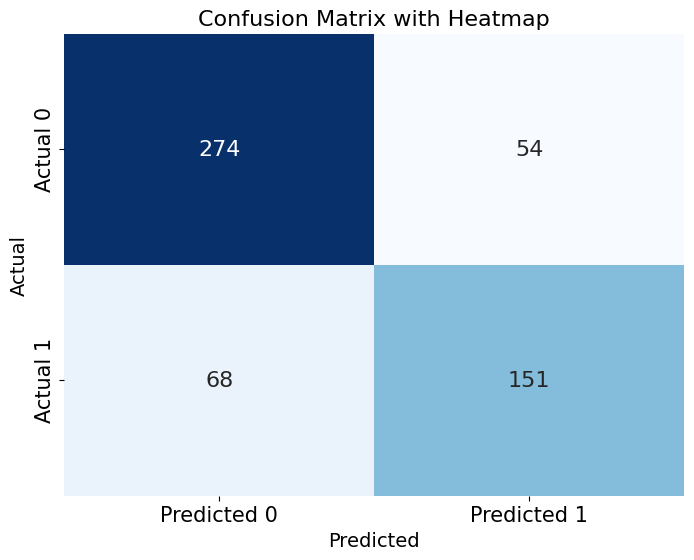

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(max_depth=32, max_features='log2', min_samples_leaf=15,
                       min_samples_split=10, n_estimators=111)  # n_estimators is the number of trees

X = main_df4.drop(columns=['pass_outcome'])
y = main_df4['pass_outcome']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Fit the model
rf_model.fit(x_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(x_test)
y_pred_train = rf_model.predict(x_train)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_train = accuracy_score(y_train, y_pred_train)

print("Random Forest Test Accuracy:", accuracy_rf)
print("Random Forest Train Accuracy:", accuracy_train)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plotting the confusion matrix with a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 16})  # Increase the font size of the numbers inside the heatmap

# Add labels, title, and axis ticks with larger font size
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix with Heatmap', fontsize=16)

# Increase the font size of the axis ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.show()


In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the objective function for optimization
def objective(trial):
    rf = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        max_depth=trial.suggest_int('max_depth', 10, 50),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # Removed 'auto'
    )
    score = cross_val_score(rf, x_train, y_train, n_jobs=-1, cv=5, scoring='accuracy')
    return score.mean()

# Run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(x_train, y_train)


[I 2024-11-13 12:06:05,447] A new study created in memory with name: no-name-fe614de0-7090-4725-a147-43f6b30d2dca
[I 2024-11-13 12:06:14,016] Trial 0 finished with value: 0.7429386976982689 and parameters: {'n_estimators': 113, 'max_depth': 38, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7429386976982689.
[I 2024-11-13 12:06:19,304] Trial 1 finished with value: 0.7492413716100538 and parameters: {'n_estimators': 76, 'max_depth': 44, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7492413716100538.
[I 2024-11-13 12:06:25,222] Trial 2 finished with value: 0.7486307884442018 and parameters: {'n_estimators': 132, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 1 with value: 0.7492413716100538.
[I 2024-11-13 12:06:31,983] Trial 3 finished with value: 0.7451746768230653 and parameters: {'n_estimators': 130, 'max_depth': 27, 

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd

# Adjusting X and y as per your requirement
X = main_df4.drop('pass_outcome', axis=1)  # Features (dropping 'pass_outcome' column)
y = main_df4['pass_outcome']  # Target (the 'pass_outcome' column from main_df4)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the Logistic Regression model
log_reg.fit(x_train, y_train)

# Predict using the Logistic Regression model
y_pred = log_reg.predict(x_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)

print(f"Logistic Regression Accuracy: {accuracy:.2f}")

Logistic Regression Accuracy: 0.68


<ipython-input-158-38e34cf33f30>:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


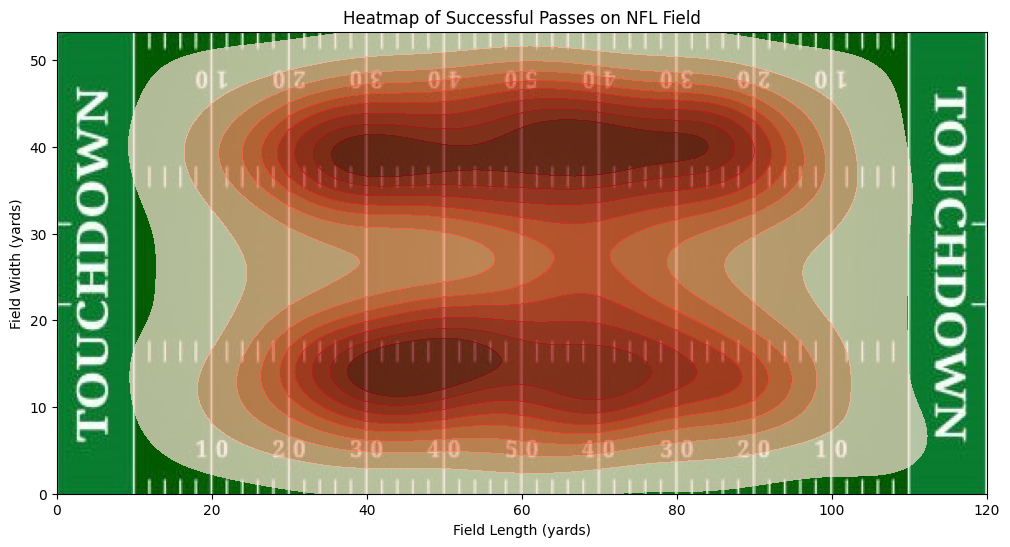

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Sample data - Replace with your actual DataFrame
# df = pd.DataFrame({'receiver_x': ..., 'receiver_y': ..., 'success': ...})
df = main_df4[['receiver x', 'receiver y', 'pass_outcome']]  # Assuming 'pass_outcome' is binary: 1 for success, 0 for failure

# Separate successful plays
successful_plays = df[df['pass_outcome'] == 1]

# Load the NFL field image
field_img = mpimg.imread('/content/istockphoto-1406263895-612x612.jpg')  # Replace with the path to your NFL field image

plt.figure(figsize=(12, 6))

# Display the field image
plt.imshow(field_img, extent=[0, 120, 0, 53.3], aspect='auto')

# Overlay KDE plot for successful plays
sns.kdeplot(
    x=successful_plays['receiver x'],
    y=successful_plays['receiver y'],
    cmap="Reds",
    shade=True,
    alpha=0.7,
    bw_adjust=1
)

# Adjust plot limits to match the NFL field dimensions
plt.xlim(0, 120)  # Length of the field in yards (end zone to end zone)
plt.ylim(0, 53.3)  # Width of the field in yards

plt.xlabel("Field Length (yards)")
plt.ylabel("Field Width (yards)")
plt.title("Heatmap of Successful Passes on NFL Field")
plt.show()


<ipython-input-22-eb353deb340c>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="pass_outcome", y="catchSeparation", data=main_df4, palette="coolwarm")


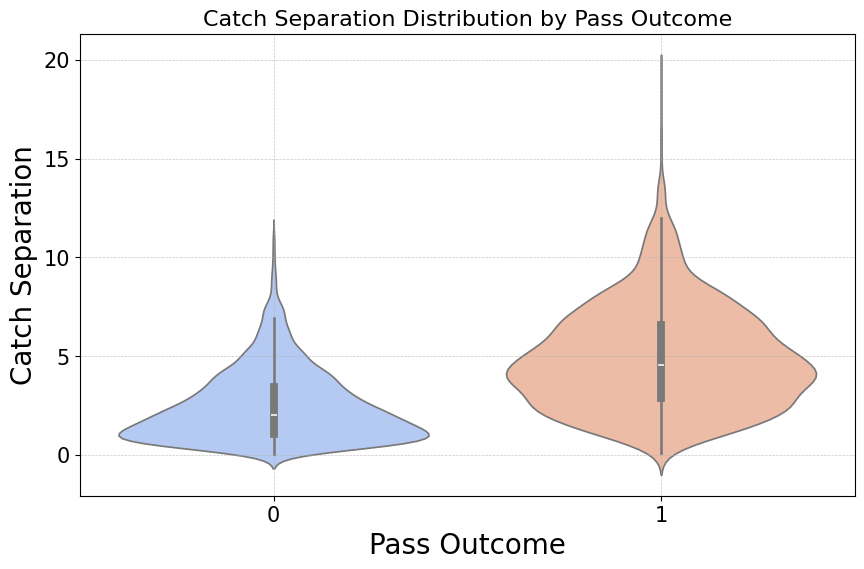

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x="pass_outcome", y="catchSeparation", data=main_df4, palette="coolwarm")

# Add a background grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Increase text size
plt.title("Catch Separation Distribution by Pass Outcome", fontsize=16)
plt.xlabel("Pass Outcome", fontsize=20)
plt.ylabel("Catch Separation", fontsize=20)

# Increase tick label size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Show the plot
plt.show()


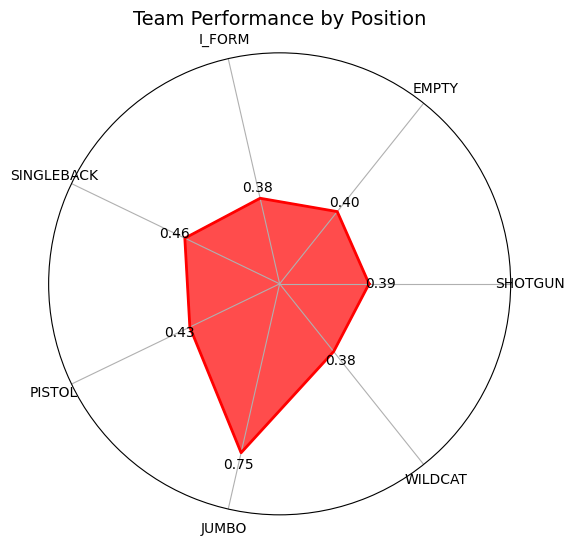

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example categories for the radar chart
categories = ['SHOTGUN', 'EMPTY', 'I_FORM', 'SINGLEBACK', 'PISTOL', 'JUMBO', 'WILDCAT']
values = [0.38707037643207853, 0.4, 0.38, 0.4556291390728477, 0.4315068493150685, 0.75, 0.375]  # Example pass success rates

# Close the plot by appending the first value to the end
values += values[:1]
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Set the radar chart scale to 1
ax.set_ylim(0, 1)

# Plot the radar chart
ax.fill(angles, values, color='red', alpha=0.7)
ax.plot(angles, values, color='red', linewidth=2)

# Remove radial ticks
ax.set_yticks([])

# Set the category labels and adjust for better visibility
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, rotation=45, ha='center', fontsize=10, color='black')

# Adding values on the plot for each category
for angle, value, label in zip(angles, values, categories):
    ax.text(angle, value + 0.05, f"{value:.2f}", ha='center', va='center', fontsize=10, color='black')

# Set title and display the plot
ax.set_title("Team Performance by Position", size=14)
plt.show()
